In [1]:
import xarray as xr
import math
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import torch.nn as nn
import torch
import gpytorch
import matplotlib.pyplot as plt
import cf_units
import datetime
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [2]:
#First load data from xarray
sea_level_picontrol = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol.zarr')
rechunked = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol_rechunked.zarr')

# Enter coordinates 
coords = (29, -90)   #NOLA

# Grab the approximate chunk for provided coords
area_approx = rechunked.sea_level.sel(xt_ocean=coords[1], yt_ocean=coords[0], method="nearest")

# Set up the DataArray with data as the sea level of the approximate area, and time as it's dimension
coords_dict = {'time': sea_level_picontrol['time']}
area_sea_level = xr.DataArray(area_approx, dims=('time'), coords=coords_dict)

# Turn Data to tensors
time_int = cf_units.date2num(area_sea_level.time,'days since 0185-01-01 12:00:00' , calendar='julian')

In [3]:
#Functions to remove gap(s) from the data

def set_x_and_y(indexes, time, sea_level):
    """
    Input: array of indexes
    Output: Tensors for x and y (either train or test)
    """
    x = []
    y = [] 

    for i in indexes:
        x.append(time[i])
        y.append(sea_level[i])
        
    x = (np.array(x)).astype(float)
    y = (np.array(y)).astype(float)
        
    x = torch.FloatTensor(x).squeeze()
    y = torch.FloatTensor(y).squeeze()
    
    return x, y

def remove_gaps(indexes, gaps, gap_size, first_possible_gap):
    last_possible_gap = len(indexes)-gap_size
    gaps_arr = np.random.choice(indexes[first_possible_gap:last_possible_gap], gaps, False).reshape(-1, 1)
    for gap in gaps_arr:
        i = np.arange(gap, gap+gap_size)
        indexes = np.delete(indexes, i, 0)
        
    return indexes
        
def select_training_gaps(data_size, gaps, gap_size, first_possible_gap, time, sea_level):
    """
    Input: sea_level data
    Output: Tensors with x_train y_train, x_test, and y_test
    """
    
    # Randomly choose points for training, the rest for testing
    indexes = list(range(0, data_size))
    training_indexes = remove_gaps(indexes, gaps, gap_size, first_possible_gap)
    testing_indexes = np.setdiff1d(indexes, training_indexes).reshape(-1, 1)
    
    x_train, y_train = set_x_and_y(training_indexes, time, sea_level)
    x_test, y_test = set_x_and_y(testing_indexes, time, sea_level)
    
    return x_train, y_train, x_test, y_test

In [4]:

# Change how many points we're using, how many gaps in the data, 
# the size of the gaps and where the first gap can possibly start
data_size = 700
gaps = 1
gap_size = 100
first_possible_gap = 100

#Input: size of data, number of gaps, size of gaps, time data, sea level data
x_train, y_train, x_test, y_test = select_training_gaps(data_size, gaps, gap_size, first_possible_gap,
                                                        time_int, area_sea_level)

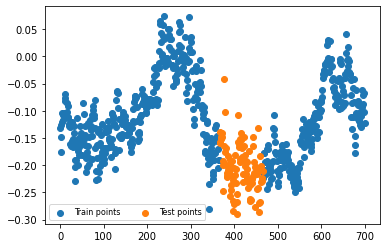

In [5]:
# Graph Our training and testing points
train_plt = plt.scatter(x_train, y_train)
test_plt = plt.scatter(x_test, y_test)
plt.legend((train_plt, test_plt),
           ('Train points', 'Test points'),
           loc='lower left',
           scatterpoints=1,
           ncol=3,
           fontsize=8)
plt.show()

In [7]:
# Calculate mean std of x and y variables
xtrain_mean = x_train.mean()
ytrain_mean = y_train.mean()

xtrain_std = x_train.std()
ytrain_std = y_train.std()

# Normalize training data
x_train = (x_train - x_train.mean()) / x_train.std()
y_train = (y_train - y_train.mean()) / y_train.std()

# Normalize testing data
x_test = (x_test - xtrain_mean) / xtrain_std
y_test = (y_test - ytrain_mean) / ytrain_std

#Concatenate and Sort all x indicies
full_x, indicies = torch.sort(torch.cat((x_train, x_test)))
full_x = torch.FloatTensor(full_x).squeeze()



#All you need to describe a gp is a mean and covariance, simplest way is to make a class that has both of those. Then you have everything you need to compose a GP
#Torch is primarily DL, and they work with a forward function, it gives you a multivariate normal distribution with that variable
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel( gpytorch.kernels.MaternKernel())
# gpytorch.kernels.RBFKernel()
# gpytorch.kernels.PeriodicKernel()


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train, y_train, likelihood)

In [9]:

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 40


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
#is a optimization alg for stochastic gradient descent for training dl models, is good for handling sparse gradients on noisy problems
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(x_train)
    # Calc loss and backprop gradients
    # the loss is the marginal log likelihood, and then we just backprop to go back and update things
    loss = -mll(output, x_train)
    loss.backward()
#     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#         i + 1, training_iter, loss.item(),
#         model.covar_module.base_kernel.lengthscale.item(),
#         model.likelihood.noise.item()
#     ))
    optimizer.step()

/ext3/miniconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


In [11]:
#Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
   
    # Normalize testing data
    x_test = (x_test - xtrain_mean) / xtrain_std
    y_test = (y_test - ytrain_mean) / ytrain_std

    #Concatenate and Sort all x indicies
    full_x, indicies = torch.sort(torch.cat((x_train, x_test)))
    full_x = torch.FloatTensor(full_x).squeeze()
    observed_pred = likelihood(model(x_test))
    
    #test_x = torch.linspace(0,4000, 4000)
    #test_x = (test_x - x_mean)/x_std
    #test_y = (test_y - y_mean)/y_std
    post_samples = model(x_test).sample(sample_shape=torch.Size((1, )))
    

/ext3/miniconda3/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


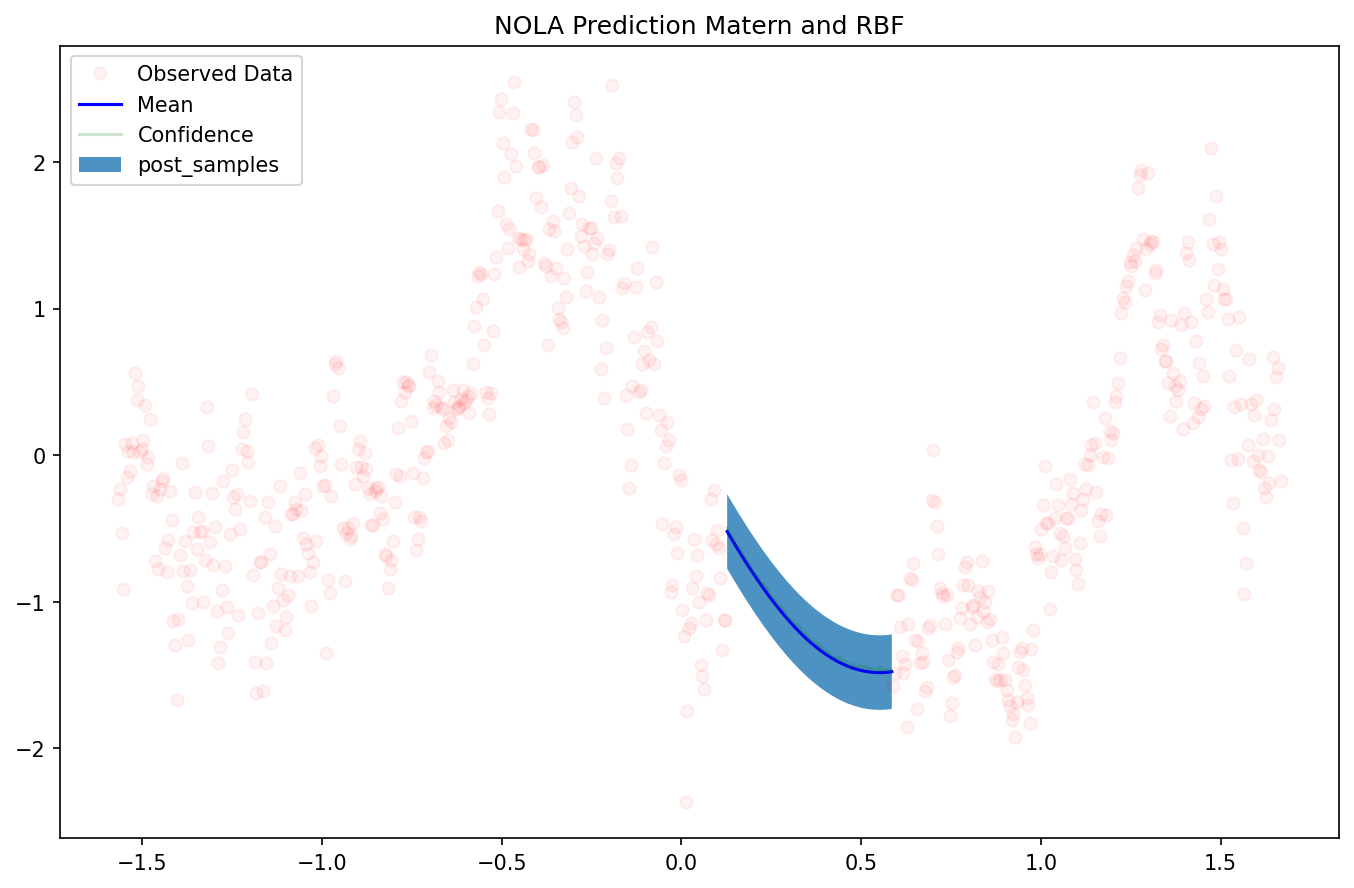

In [16]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(11, 7),dpi=150)
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as red line
    ax.plot(x_train.numpy(), y_train.numpy(), 'or', alpha= 0.05)
    # Plot predictive means as blue line
    ax.plot(x_test.numpy() ,  observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    
    ax.plot(x_test.numpy() ,  post_samples.t(), 'g', alpha= .2)

    ax.fill_between(x_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.8)
    #ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence', 'post_samples'])
    

    plt.title('NOLA Prediction Matern and RBF')
    